In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from time import time
import itertools
import random

Alright, here's my approach right now: go through and find as many anchor points as I can, points where I can nail down the count at that point with 100% confidence. These happen regularly, I could write down the expected distance between them. It's constant in n, and the expected max over all of them will grow only slowly with n. Right now it results in about 70% accuracy with random guessing when I don't know.

This will yield stretches where I don't know the count, only an upper and a lower bound on it and the length of the stretch, call that m. This number is usually small, less than 10. I'll also know how much the true count increased over that time, say k<m. Therefore there are m-choose-k possible bitstrings corresponding to the true bits. We can iterate over them and check if they are consistent with the noise model. I believe all consistent guesses have the same likelihood, so we grab one and use that. 

All that remains is to:
1. Get it working, indices and all aligned.
1. Check if it's fast enough. If not, try random guessing on big unknown stretches.

In [45]:
def create_instance(n, has_prior=False):
    # set up a problem instance
    if not has_prior:
        s = np.random.binomial(1,0.5,size=n)
    else:
        prior_probs = np.random.choice((1/3,2/3), size=n)
        s = np.random.binomial(1, prior_probs, size=n)
        prior = np.zeros(n, dtype='int')
        prior[prior_probs == 2/3] = 1
    counter = np.zeros(n, dtype='int')
    counter[0] = s[0]
    for i in range(1,n):
        counter[i] = counter[i-1] + s[i]
    z = np.random.randint(0,2,size=n)
    a = counter + z
    
    if has_prior:
        return a, s, z, counter, prior
    else:
        return a, s, z, counter
        
def fixed_counts(a):
    # non-exhaustive linear-time solving for when we know the true count exactly
    n = len(a)
    count = -1*np.ones(n, dtype='int')
    
    if a[0] == 0:
        count[0] = 0
    elif a[0] == 2:
        count[0] = 1

    for i in range(1,n):
        if a[i] == a[i-1] + 2:
            count[i] = a[i] - 1
            count[i-1] = a[i-1] 
        elif a[i] == a[i-1] - 1:
            count[i] = a[i]
            count[i-1] = a[i]

    # TODO: last couple passes change very little
    passes = 0
    modified = -1
    while passes < 10 and modified!=0:
        modified = 0
        passes += 1
        for i in range(1,n):
            if count[i] == -1:
                if a[i] == count[i-1]:
                    count[i] = count[i-1]
                    modified += 1
                if a[i] == count[i-1] + 2:
                    count[i] = count[i-1] + 1
                    modified += 1
        for i in range(n-1):
            if count[i] == -1:
                if a[i] == count[i+1] + 1:
                    count[i] = count[i+1]
                    modified += 1

    # this closes any size-one holes
    for i in range(1,n-1):
        if (count[i]==-1) and (count[i+1]!=-1) and (count[i-1]!=-1):
            if count[i+1]==count[i-1]:
                count[i] = count[i-1]
            if count[i+1]==count[i-1]+2:
                count[i] = count[i-1] + 1

    return count

def find_gaps(partial_counts):
    """find stretches where we don't know the count"""
    n = len(partial_counts)
    indices = []
    # first, check the start
    i = 1
    if partial_counts[0] == -1:
        for i in range(1,n):
            if partial_counts[i] != -1:
                indices.append([0,i])
                break
                
    # now for general
    on = False
    for j in range(i,n):
        if not on and partial_counts[j] == -1:
            on = True
            start = j
        if on and partial_counts[j] != -1:
            on = False
            indices.append([start,j])
        if on and j == n-1:
            indices.append([start,n])
            break  # we're at the end
            
    indices.sort(key= lambda x: x[0]-x[1]) # sort, shortest first
    
    return indices

def guess_single_holes(counts):
    """just do a random guess on the size-one holes"""
    n = len(counts)
    if counts[0]==-1 and counts[1]!=-1:
        counts[0] = 0
    if counts[-1]==-1 and counts[-2]!=-1:
        counts[-1] = counts[-2] 
    
    for i in range(1,n-1):
        if (counts[i]==-1) and (counts[i+1]!=-1) and (counts[i-1]!=-1):
            counts[i] = counts[i-1]
    return counts

def counts_to_bits(counts):
    """turn a guessed count vector into bits"""
    n = len(counts)
    x_hat = np.zeros(n, dtype='int')
    x_hat[0] = counts[0]
    for i in range(1,n):
        x_hat[i] = counts[i] - counts[i-1]
    return x_hat

def solver(obs, prior, total, maxtime):
    # brute force search for a consistent explanation of a subarray
    # this is minimum working code, folks
    n = len(obs)

    start = time()
    
    # these keep track of the best we've seen so far
    best_diff = float('Inf')
    best_count = None
    highest_prior = 0
    best_match = None
    
    if prior is None:
        if total >= 2:  
            nonzeros = itertools.chain(itertools.combinations(range(n), total),
                                        itertools.combinations(range(n), total-1))
            for indices in nonzeros:
                x_hat = np.zeros(n, dtype='int')
                x_hat[np.array(indices)] = 1
                count_hat = np.cumsum(x_hat)
                diff = obs - count_hat
                deviation = max(np.max(diff),np.max(-diff)+1)
                if deviation <= 1:
                    return count_hat
                else:
                    if deviation < best_diff:
                        best_count = count_hat
                if time() - start > maxtime:
                    break
        else:  # we're solve without a fixed upper total, via permutation
            bitstrings = itertools.product(range(2), repeat=n)
            for bits in bitstrings:
                x_hat = np.array(bits)
                count_hat = np.cumsum(x_hat)
                diff = obs - count_hat
                deviation = max(np.max(diff),np.max(-diff)+1)
                if deviation <= 1:
                    return count_hat
                if time() - start > maxtime:
                    break
    else: # have a prior
        if total >= 2:  
            # first, just check if the max-prior is possible
            count_hat = np.cumsum(prior)
            diff = obs - count_hat
            deviation = max(np.max(diff),np.max(-diff)+1)
            if deviation <= 1 and abs(count_hat[-1] - total) <= 1:
                return count_hat
            
            # otherwise, brute-force as normal
            nonzeros = itertools.chain(itertools.combinations(range(n), total),
                                        itertools.combinations(range(n), total-1))
            for indices in nonzeros:
                x_hat = np.zeros(n, dtype='int')
                x_hat[np.array(indices)] = 1
                count_hat = np.cumsum(x_hat)
                diff = obs - count_hat
                deviation = max(np.max(diff),np.max(-diff)+1)
                match_prior = np.sum(x_hat == prior)
                if deviation <= 1:
                    if match_prior == n-1:  # because we know matching the prior wasn't feasible
                        return count_hat
                    else:
                        if match_prior > highest_prior:
                            highest_prior = match_prior
                            best_match = count_hat 
                else:
                    if deviation < best_diff:
                        best_diff = deviation
                        best_count = count_hat
                if time() - start > maxtime:
                    break
                    
        else:  # we're solving without an upper number, i.e. at the end
            # check if the max-prior is feasible
            count_hat = np.cumsum(prior)
            diff = obs - count_hat
            deviation = max(np.max(diff),np.max(-diff)+1)
            if deviation <= 1:
                return count_hat
            
            bitstrings = itertools.product(range(2), repeat=n)
            for bits in bitstrings:
                x_hat = np.array(bits)
                count_hat = np.cumsum(x_hat)
                diff = obs - count_hat
                deviation = max(np.max(diff),np.max(-diff)+1)
                match_prior = np.sum(x_hat == prior)
                if deviation <= 1:
                    if match_prior == n-1:
                        return count_hat
                    else:
                        if match_prior > highest_prior:
                            highest_prior = match_prior
                            best_match = count_hat
                else:
                    if deviation < best_diff:
                        best_diff = deviation
                        best_count = count_hat
                if time() - start > maxtime:
                    break
    # breaking takes us here, return the best guess we have so far

    if best_match is not None:
        return best_match
    elif best_count is not None:
        return best_count
    else:
        return count_hat
            
def recover(a, prior=None):
    """base recovery"""
    n = len(a)
    
    partial_counts = fixed_counts(a)
    counts = guess_single_holes(partial_counts)
    
    indices = find_gaps(counts)
    # iterate over the short gaps
    for index in indices:
        start, end = index[0], index[1]
        if start == 0:
            lo = 0
        else:
            lo = counts[start-1]
        if end == n:
            hi = -1
        else:
            hi = counts[end] - lo

        obs = a[start:end] - lo
        
        if n == 50000:
            if prior is not None:
                counts[start:end] = solver(obs, prior[start:end], hi, 0.1) + lo
            else:
                counts[start:end] = solver(obs, prior=None, total=hi, maxtime=0.1) + lo            
        else:
            if prior is not None:
                counts[start:end] = solver(obs, prior[start:end], hi, 1) + lo
            else:
                counts[start:end] = solver(obs, prior=None, total=hi, maxtime=1) + lo            
                
    s_hat = counts_to_bits(counts)
    return s_hat


n: 100
run: 0
run: 1
run: 2
run: 3
run: 4
run: 5
run: 6
run: 7
run: 8
run: 9
run: 10
run: 11
run: 12
run: 13
run: 14
run: 15
run: 16
run: 17
run: 18
run: 19

n: 500
run: 0
run: 1
run: 2
run: 3
run: 4
run: 5
run: 6
run: 7
run: 8
run: 9
run: 10
run: 11
run: 12
run: 13
run: 14
run: 15
run: 16
run: 17
run: 18
run: 19

n: 1000
run: 0
run: 1
run: 2
run: 3
run: 4
run: 5
run: 6
run: 7
run: 8
run: 9
run: 10
run: 11
run: 12
run: 13
run: 14
run: 15
run: 16
run: 17
run: 18
run: 19

n: 5000
run: 0
run: 1
run: 2
run: 3
run: 4
run: 5
run: 6
run: 7
run: 8
run: 9
run: 10
run: 11
run: 12
run: 13
run: 14
run: 15
run: 16
run: 17
run: 18
run: 19

n: 50000
run: 0
run: 1
run: 2
run: 3
run: 4
run: 5
run: 6
run: 7
run: 8
run: 9
run: 10
run: 11
run: 12
run: 13
run: 14
run: 15
run: 16
run: 17
run: 18
run: 19
total: 273.4214463233948


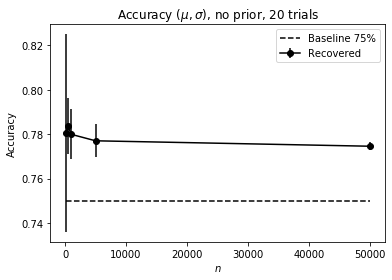

[0.7805   0.7837   0.77995  0.77702  0.774572]
[0.04455053 0.0125104  0.01127597 0.00735524 0.00187273]


In [47]:
# check the whole thing
np.random.seed(5)
ns = [100, 500, 1000, 5000, 5*int(1e4)]
# ns = [5*int(1e4)]
runs = 20

accs = np.zeros((len(ns), runs))

big = time()
for j, n in enumerate(ns):
    all_start = time()
    for run in range(runs):
        a, true_s, true_z, true_counts = create_instance(n, has_prior=False)

        start = time()
        s_hat = recover(a, prior=None)
        end = time()

        accs[j, run] = 1 - np.sum(np.abs(s_hat -true_s)) / n
        if False:
            print('accuracy:', accs[j,run])
            print('time:', end-start)
            print()
            
    all_end = time()
    if False:
        print('n:', n)
        print('time:', all_end-all_start)
        print('avg:', np.sum(accs[j,:])/runs )
        print()
print('total:', time()-big)

avg_accs = np.sum(accs, axis=1) / runs
stds = np.std(accs, axis=1)
plt.errorbar(ns, avg_accs, yerr=stds, fmt='ko-', label='Recovered')
plt.plot(ns, 0.75*np.ones(len(ns)), 'k--', label='Baseline 75%')
plt.title('Accuracy ($\mu, \sigma$), no prior, '+str(runs)+' trials')
plt.xlabel('$n$')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(avg_accs)
print(stds)



n: 100
run: 0
run: 1
run: 2
run: 3
run: 4
run: 5
run: 6
run: 7
run: 8
run: 9
run: 10
run: 11
run: 12
run: 13
run: 14
run: 15
run: 16
run: 17
run: 18
run: 19

n: 500
run: 0
run: 1
run: 2
run: 3
run: 4
run: 5
run: 6
run: 7
run: 8
run: 9
run: 10
run: 11
run: 12
run: 13
run: 14
run: 15
run: 16
run: 17
run: 18
run: 19

n: 1000
run: 0
run: 1
run: 2
run: 3
run: 4
run: 5
run: 6
run: 7
run: 8
run: 9
run: 10
run: 11
run: 12
run: 13
run: 14
run: 15
run: 16
run: 17
run: 18
run: 19

n: 5000
run: 0
run: 1
run: 2
run: 3
run: 4
run: 5
run: 6
run: 7
run: 8
run: 9
run: 10
run: 11
run: 12
run: 13
run: 14
run: 15
run: 16
run: 17
run: 18
run: 19

n: 50000
run: 0
run: 1
run: 2
run: 3
run: 4
run: 5
run: 6
run: 7
run: 8
run: 9
run: 10
run: 11
run: 12
run: 13
run: 14
run: 15
run: 16
run: 17
run: 18
run: 19
total time: 1263.021996974945


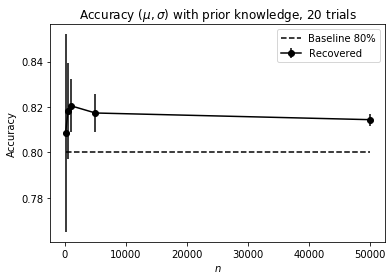

[0.8085   0.8182   0.8205   0.81734  0.814407]
[0.04350575 0.02126876 0.01171111 0.0082217  0.00269974]


In [50]:
# check the whole thing, with the prior
np.random.seed(5)
ns = [100, 500, 1000, 5000, 5*int(1e4)]
runs = 20

accs = np.zeros((len(ns), runs))

big = time()
for j, n in enumerate(ns):
    print()
    print('n:', n)
    all_start = time()
    for run in range(runs):
        print('run:', run)
        a, true_s, true_z, true_counts, prior = create_instance(n, has_prior=True)

        start = time()
        s_hat = recover(a, prior=prior)
        end = time()

        accs[j, run] = 1 - np.sum(np.abs(s_hat -true_s)) / n
        if False:
            print('accuracy:', accs[j,run])
            print('time:', end-start)
            print()
            
    all_end = time()
    if False:
        print('n:', n)
        print('time:', all_end-all_start)
        print('avg:', np.sum(accs[j,:])/runs )
        print()
print('total time:', time()-big)

avg_accs = np.sum(accs, axis=1) / runs
stds = np.std(accs, axis=1)
plt.errorbar(ns, avg_accs, yerr=stds, fmt='ko-', label='Recovered')
plt.plot(ns, 0.8*np.ones(len(ns)), 'k--', label='Baseline 80%')
plt.title('Accuracy ($\mu, \sigma$) with prior knowledge, '+str(runs)+' trials')
plt.xlabel('$n$')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(avg_accs)
print(stds)


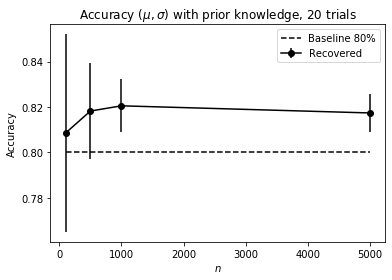

In [39]:
plt.plot(ns, 0.8*np.ones(len(ns)), 'k--', label='Baseline 80%')
plt.errorbar(ns, avg_accs, yerr=stds, fmt='ko-', label='Recovered')
plt.title('Accuracy ($\mu, \sigma$) with prior knowledge, '+str(runs)+' trials')
plt.xlabel('$n$')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

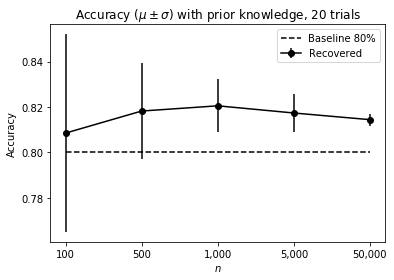

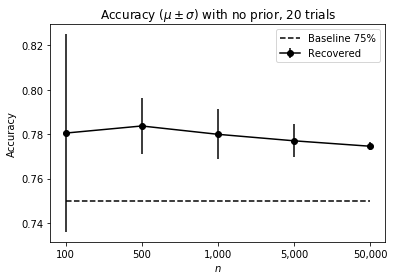

In [60]:
# location for plots
ns = [100, 500, 1000, 5000, 5*int(1e4)]
no_prior_accs = [0.7805,   0.7837,   0.77995,  0.77702, 0.774572]
no_prior_stds = [0.04455053, 0.0125104 , 0.01127597, 0.00735524, 0.00187273]
prior_accs = [0.8085 ,  0.8182 ,  0.8205  , 0.81734 , 0.814407]
prior_stds = [0.04350575, 0.02126876, 0.01171111 ,0.0082217,  0.00269974]

str_ns = ['100', '500', '1,000', '5,000', '50,000']

plt.plot(str_ns, 0.8*np.ones(len(ns)), 'k--', label='Baseline 80%')
plt.errorbar(str_ns, prior_accs, yerr=prior_stds, fmt='ko-', label='Recovered')
plt.title('Accuracy ($\mu \pm \sigma$) with prior knowledge, '+str(runs)+' trials')
plt.xlabel('$n$')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('problem_1_prior.png')
plt.show()

plt.plot(str_ns, 0.75*np.ones(len(ns)), 'k--', label='Baseline 75%')
plt.errorbar(str_ns, no_prior_accs, yerr=no_prior_stds, fmt='ko-', label='Recovered')
plt.title('Accuracy ($\mu \pm \sigma$) with no prior, '+str(runs)+' trials')
plt.xlabel('$n$')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('problem_1_no_prior.png')
plt.show()

n: 6
n: 8
n: 10
n: 12
n: 14
n: 16
n: 18
total: 55.66984415054321


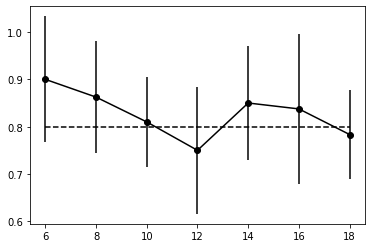

In [24]:
# check just the solver, with prior
np.random.seed(5132)
ns = [6, 8, 10, 12, 14, 16, 18]
runs = 10

accs = np.zeros((len(ns), runs))

big = time()
for j, n in enumerate(ns):
    print('n:', n)
    all_start = time()
    for run in range(runs):
        a, true_s, true_z, true_counts, prior = create_instance(n, has_prior=True)

        start = time()
        counts = solver(a, prior=prior, total=-1, maxtime=40)
        end = time()

        s_hat = np.zeros(n, dtype='int')
        s_hat[0] = counts[0]
        for i in range(1,n):
            s_hat[i] = counts[i] - counts[i-1]

        accs[j, run] = 1 - np.sum(np.abs(s_hat -true_s)) / n
        if False:
            print('accuracy:', acc)
            print('time:', end-start)
            print()
    all_end = time()
    if False:
        print('n:', n)
        print('time:', all_end-all_start)
        print('avg:', np.sum(accs[j,:])/runs )
        print()
print('total:', time()-big)

avg_accs = np.sum(accs, axis=1) / runs
stds = np.std(accs, axis=1)
plt.errorbar(ns, avg_accs, yerr=stds, fmt='ko-')
plt.plot(ns, 0.8*np.ones(len(ns)), 'k--')
plt.show()

In [224]:
np.random.seed(5912)
n = 1000
runs = 10

total_error = 0

for i in range(runs):
    a, true_s, true_z, true_counts = create_instance(n)
    all_go = time()
    
    partial_counts = fixed_counts(a)
    counts = guess_single_holes(partial_counts)
    
    indices = find_holes(counts)
    for index in indices:
        start, end = index[0], index[1]
        if start == 0:
            lo = 0
        else:
            lo = counts[start-1]
        if end == n:
            hi = -1
        else:
            hi = counts[end] - lo

        obs = a[start:end] - lo
        go = time()
#         print(index)
#         print(a[start-1:end+1])
#         print(counts[start-1:end+1])
#         print(obs)
#         print(lo)
#         print(hi)
#         print()
        piece = solver(obs, hi, 10) + lo
        stop = time()
        if (stop-go > 1):
#             print(end-start, ',', stop-go)
            foo = 1
#         print('guessed:', piece)
#         print('true:   ', true_counts[start:end])
#         print('obs:    ', obs+lo)
#         print()
        counts[start:end] = piece
    s_hat = counts_to_bits(counts)
#     print('obs:  ', a)
#     print('true: ', true_s)
#     print('guess:', s_hat)

    check_consistency(a, s_hat)

    all_stop = time()
    print('run', i, ', total time:', all_stop - all_go)
    print('accuracy:', 1 - np.sum(np.abs(s_hat-true_s))/n)
    total_error += np.sum(np.abs(s_hat-true_s))/n

print('accuracy:', 100*(1- total_error / runs))



run 0 , total time: 0.13593411445617676
accuracy: 0.788
run 1 , total time: 0.4443027973175049
accuracy: 0.8009999999999999
run 2 , total time: 0.15126776695251465
accuracy: 0.764
run 3 , total time: 1.2142999172210693
accuracy: 0.777
run 4 , total time: 0.05808401107788086
accuracy: 0.782
run 5 , total time: 1.23142671585083
accuracy: 0.762
lo
run 6 , total time: 10.106822729110718
accuracy: 0.739
lo
run 7 , total time: 10.207462310791016
accuracy: 0.778
run 8 , total time: 4.885944843292236
accuracy: 0.792
run 9 , total time: 0.08237600326538086
accuracy: 0.761
accuracy: 77.44


In [4]:
np.random.seed(5912)
n = 5*int(1e4)
a, true_s, true_z, true_count = create_instance(n)

# check fixed ones. Can reduce verbosity here.
for_sure = set()
s_hat = np.ones(n, dtype='int')
a_hat = np.zeros(n, dtype='int')
z_hat = np.zeros(n, dtype='int')
count = -1 * np.ones(n, dtype='int')

if a[0] == 0:
    count[0] = 0
elif a[0] == 2:
    count[0] = 1

for i in range(1,n):
    if a[i] == a[i-1] + 2:
        count[i] = a[i] - 1
        count[i-1] = a[i-1] 
    elif a[i] == a[i-1] - 1:
        count[i] = a[i]
        count[i-1] = a[i]

if True:
    for j in range(4):
        for i in range(1,n):
            if a[i] == count[i-1]:
                count[i] = count[i-1]
        for i in range(1,n):
            if a[i] == count[i-1] + 2:
                count[i] = count[i-1] + 1
        for i in range(n-1):
            if a[i] == count[i+1] + 1:
                count[i] = count[i+1]
                
if True:
    for i in range(1,n-1):
        if (count[i-1]!=-1) and (count[i]==-1) and (count[i+1]==count[i-1]+2):
            count[i] = count[i-1] + 1

if False:
    print("a |tru| hyp.")
    print('-------------')
    for i in range(100):
        if count[i] == -1:
            print(a[i], '|', true_count[i], '|', count[i])
        else:
            print(a[i], '|', true_count[i], '| ', count[i])
#     print('a:', a)
#     print('z:', true_z)
#     print('s:', true_s)
#     print('h:', s_hat)
# print(len(for_sure))

right = 0
errors = 0
for i in range(n):
    if count[i] != -1:
        if count[i] == true_count[i]:
            right += 1
        else:
            errors += 1        

print('frac nailed down:', right/n)
print('frac in error:', errors/n)

# convert my counter into guesses for bits
s_hat = np.random.randint(0, 2, n, dtype='int')
if count[0] == 1:
    s_hat[0] = 1
if count[0] == 0:
    s_hat[0] = 0

for i in range(1,n):
    if count[i] != -1:
        if count[i] == count[i-1] + 1:
            s_hat[i] = 1
        if count[i] == count[i-1]:
            s_hat[i] = 0

print('frac correct:', 1 - np.sum( np.abs(true_s - s_hat))/n)
print(true_s)
print(s_hat)


frac nailed down: 0.53088
frac in error: 2e-05
frac correct: 0.708
[0 1 0 ... 1 1 0]
[0 0 1 ... 1 1 0]


In [ ]:
if True:
    print("a |tru| hyp.")
    print('-------------')
    for i in range(50):
        if count[i] == -1:
            print(a[i], '|', true_count[i], '|', count[i])
        else:
            print(a[i], '|', true_count[i], '| ', count[i])

In [6]:
start, end = 37, 45
lo = 22
hi = 28
print(count[start:end])
print(a[start:end])
# print(a[12:29])
# print(true_s[12:29])
# print(s_hat[12:29])
# print()
B = np.tril(np.ones((end-start,end-start), dtype='int'))
# print(B)
# print()

# print(true_s[12:29])
# print(a[12:29] - 4)
# print(true_z[12:29])
# print()
# print(B@true_s[start:end] + true_z[start:end])
# print(a[start:end] - count[start-1])

print()
print('brute force!')
y = a[start:end] - lo
print('y:', y)
print('s:', true_s[start:end])

bitstrings = itertools.product(range(2), repeat=end-start)
consistent = 0

for index in indices:
    start, end = index[0], index[1]+1
    
    for bit in bitstrings:
        x_hat = np.array(bit)

        count_hat = B@x_hat
        if count_hat[-1] != hi:
            diff =  y - count_hat

            if np.max(np.abs(diff))<=1:
                consistent += 1
                if False:
                    print('guess:', x_hat)
                    print('diff:', diff)
                    print('counts:', B@x_hat + lo)
                    print('truth: ', true_count[start:end])
                    print('error:', np.sum(np.abs(diff)))
                    print()
                    print('obs a:', a[start:end])
                    print('found:', B@x_hat + lo + diff)
                    print('---------------')
            if consistent >=10:
                break
    print(consistent)


[-1 -1 -1 -1 -1 -1 -1 28]
[23 24 24 25 26 27 28 29]

brute force!
y: [1 2 2 3 4 5 6 7]
s: [1 0 1 0 1 1 1 1]
guess: [0 1 0 1 1 1 1 1]
diff: [1 1 1 1 1 1 1 1]
counts: [22 23 23 24 25 26 27 28]
truth:  [23 23 24 24 25 26 27 28]
error: 8

obs a: [23 24 24 25 26 27 28 29]
found: [23 24 24 25 26 27 28 29]
---------------
guess: [0 1 1 0 1 1 1 1]
diff: [1 1 0 1 1 1 1 1]
counts: [22 23 24 24 25 26 27 28]
truth:  [23 23 24 24 25 26 27 28]
error: 7

obs a: [23 24 24 25 26 27 28 29]
found: [23 24 24 25 26 27 28 29]
---------------
guess: [0 1 1 1 0 1 1 1]
diff: [1 1 0 0 1 1 1 1]
counts: [22 23 24 25 25 26 27 28]
truth:  [23 23 24 24 25 26 27 28]
error: 6

obs a: [23 24 24 25 26 27 28 29]
found: [23 24 24 25 26 27 28 29]
---------------
guess: [0 1 1 1 1 0 1 1]
diff: [1 1 0 0 0 1 1 1]
counts: [22 23 24 25 26 26 27 28]
truth:  [23 23 24 24 25 26 27 28]
error: 5

obs a: [23 24 24 25 26 27 28 29]
found: [23 24 24 25 26 27 28 29]
---------------
guess: [0 1 1 1 1 1 0 1]
diff: [1 1 0 0 0 0 1 1]
counts:

5693
[[5, 16], [22, 23], [25, 27], [37, 44], [49, 51], [55, 57], [67, 71], [74, 77], [92, 100], [104, 107], [112, 119], [128, 136], [139, 149], [151, 159], [162, 168], [171, 175], [182, 188], [190, 191], [193, 194], [196, 202], [204, 205], [208, 217], [226, 233], [235, 239], [241, 244], [246, 249], [251, 255], [260, 267], [271, 277], [284, 293], [295, 296], [299, 300], [303, 304], [309, 315], [317, 323], [325, 329], [331, 336], [339, 345], [349, 352], [354, 358], [364, 369], [376, 380], [383, 385], [389, 392], [394, 396], [398, 399], [402, 405], [410, 412], [415, 422], [424, 429]]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
7
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


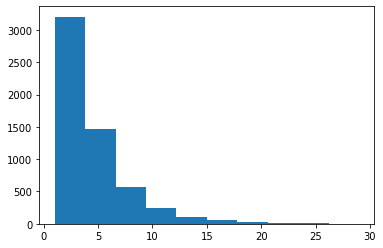

In [7]:
# ok, find the start and end of "-1" stretches
# note that I've done this for one where we know the first index
indices = []
on = False
for i in range(1,n):
    if not on and count[i] == -1:
        on = True
        start = i
    if on and count[i] != -1:
        on = False
        #         if i > start + 1:
        # only add stretches where it's greater than one
        indices.append([start,i])

print(len(indices))
print(indices[:50])
# # now fill in as needed
# for index in indices[:0]:
#     print('unknowns:', index[1]-index[0])
#     print('steps:', count[index[1]+1]-count[index[0]-1])
#     print()
    
print(count[5:16])
print(count[16])

# for index in indices[:20]:
#     start, end = index[0], index[1]
#     start_count = count[start-1]
#     end_count = count[end]
#     print(start_count, ',', end_count, ',', end-start)
    
print(count[5:16])
lengths = []
for index in indices:
    lengths.append(index[1]-index[0])
lengths = np.array(lengths)
plt.hist(lengths)
plt.show()

In [42]:
np.random.seed(591)
n = 15

runs = 10

first_err = 0
random_err = 0

start = time()
for run in range(runs):
    fresh = True
    random_errors = []
    min_err = float('Inf')
    max_err = 0
    a, true_s, true_z, true_count = create_instance(n)

    bitstrings = itertools.product(range(2), repeat=n)

    for bit in bitstrings:
        x_hat = np.array(bit)

        count_hat = np.cumsum(x_hat)
        diff = a - count_hat

        if np.max(diff)<=1 and np.min(diff)>=0:
            s_hat = np.zeros(n, dtype='int')
            s_hat[0] = count_hat[0]
            for i in range(1,n):
                s_hat[i] = count_hat[i] - count_hat[i-1]
            error = np.sum((true_s != s_hat))
            random_errors.append(error)
            if fresh:
                fresh = False
                first_err += error
            if False:
                print('guess:', x_hat)
                print('diff:', diff)
                print('counts:',  count_hat)
                print('s_hat:', s_hat)
                print('true s:', true_s)
                print('true count: ', true_count)
                print('error:', error)
                print('obs a:', a)
                print('found:', count_hat + diff)
                print('---------------')
    random_err += random.choice(random_errors)
#     print(random_errors)
#     print()
end = time()
print('all time:', end-start)

print('avg first err:', first_err/runs)
print('avg random err:', random_err/runs)

all time: 3.4007201194763184
avg first err: 2.5
avg random err: 3.6
